## Imports

In [ ]:
import pandas as pd
import os
import scipy.stats as stats
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.decomposition import PCA
import numpy as np


## Models Definitions

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost Regression': XGBRegressor()
}

## Read the Datas from file

In [ ]:
df = pd.read_excel("./sample_data/othe.xlsx")

In [ ]:
df

,Metal_I,Metal_II,Org,Func,0.1Bar
0,Cr,Hf,C,NunF,0.000875
1,Cr,Hf,C,Br,0.000535
2,Cr,Hf,C,Cl,0.000820
3,Cr,Hf,C,H,0.001186
4,Cr,Hf,C,I,0.000283
...,...,...,...,...,...
1875,Zr,Y,N,I,0.000015
1876,Zr,Y,N,O,0.000892
1877,Zr,Y,N,S,0.000346
1878,Zr,Y,N,Se,0.000119


## Preprocessing - Empty Nodes

In [ ]:
df.isna().sum()

Metal_I     0
Metal_II    3
Org         0
Func        0
0.1Bar      0
dtype: int64

In [ ]:
df = df.fillna(df['Metal_II'].mode().iloc[0])

In [ ]:
df.isna().sum()

Metal_I     0
Metal_II    0
Org         0
Func        0
0.1Bar      0
dtype: int64

## Preprocessing - Duplication

In [ ]:
df.duplicated().sum()

0

## BoxPlots

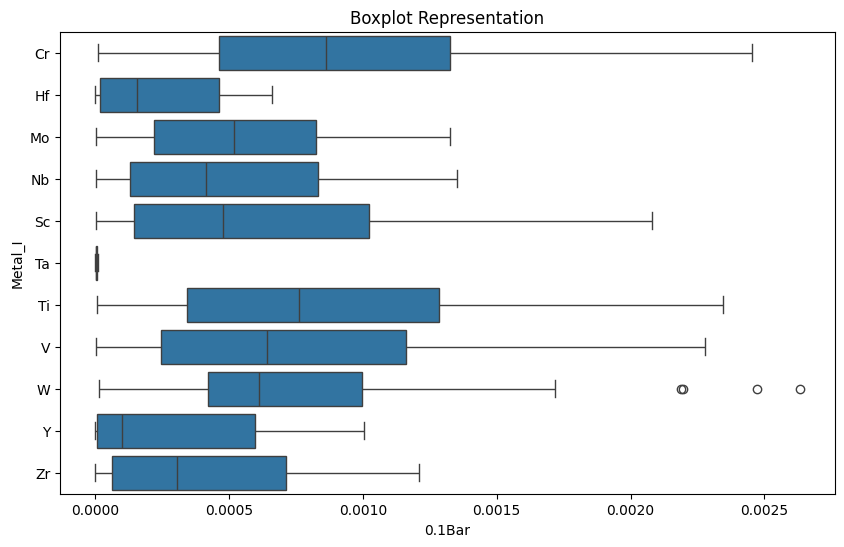

In [ ]:
# Metal_1
plt.figure(figsize=(10, 6))
sns.boxplot(x='0.1Bar', y='Metal_I', data=df)
plt.title('Boxplot Representation')
plt.xlabel('0.1Bar')
plt.ylabel('Metal_I')
plt.show()

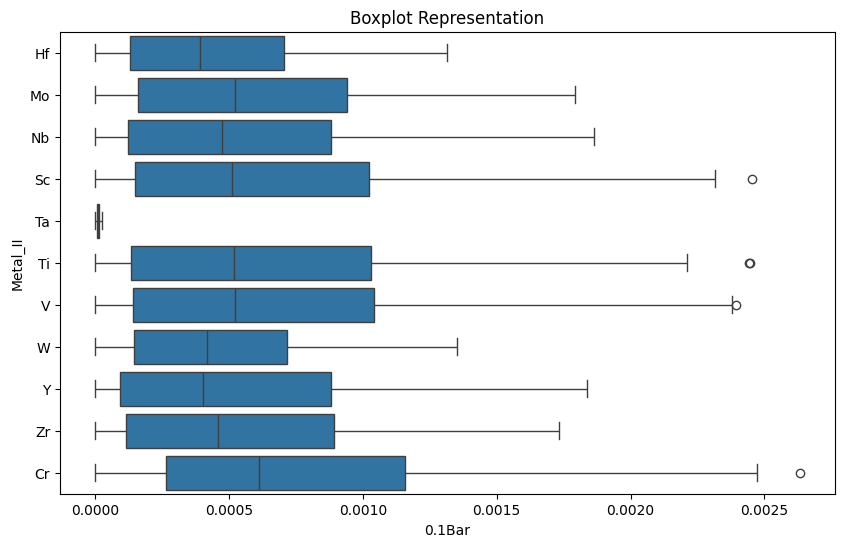

In [ ]:
# Metal_2
plt.figure(figsize=(10, 6))
sns.boxplot(x='0.1Bar', y='Metal_II', data=df)
plt.title('Boxplot Representation')
plt.xlabel('0.1Bar')
plt.ylabel('Metal_II')
plt.show()

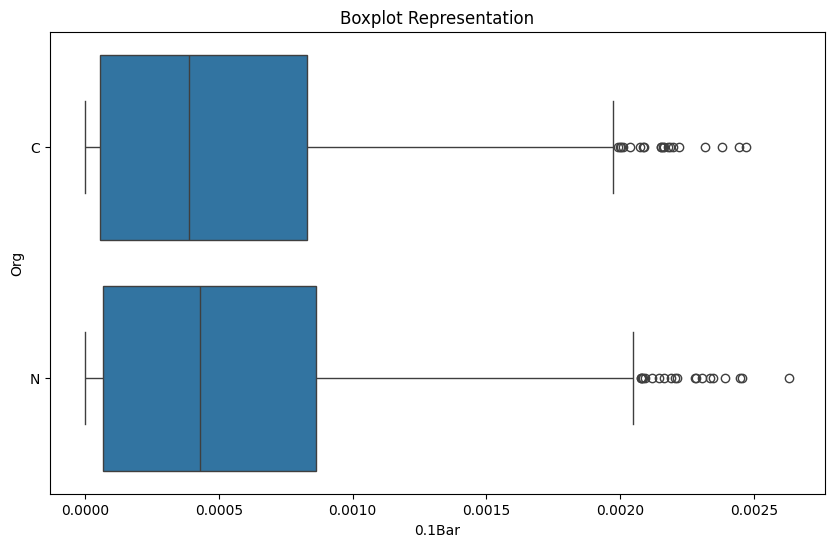

In [ ]:
# Org
plt.figure(figsize=(10, 6))
sns.boxplot(x='0.1Bar', y='Org', data=df)
plt.title('Boxplot Representation')
plt.xlabel('0.1Bar')
plt.ylabel('Org')
plt.show()

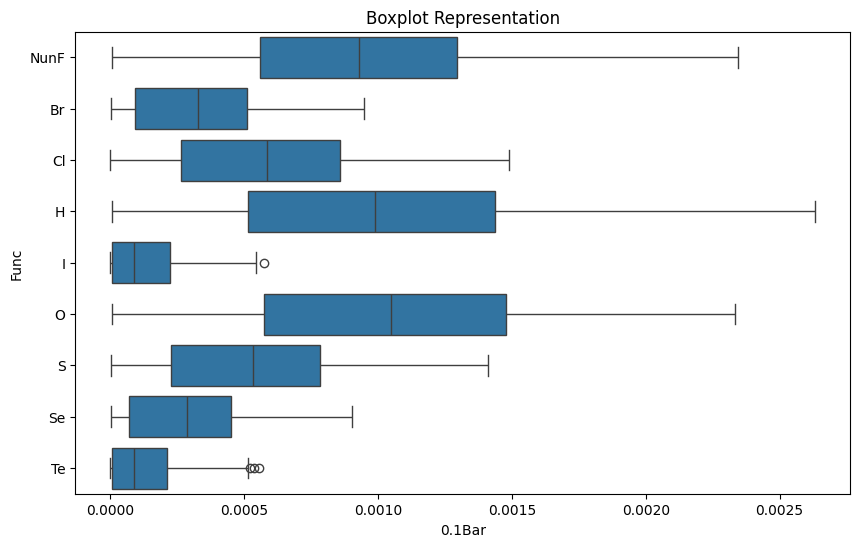

In [ ]:
# Func
plt.figure(figsize=(10, 6))
sns.boxplot(x='0.1Bar', y='Func', data=df)
plt.title('Boxplot Representation')
plt.xlabel('0.1Bar')
plt.ylabel('Func')
plt.show()

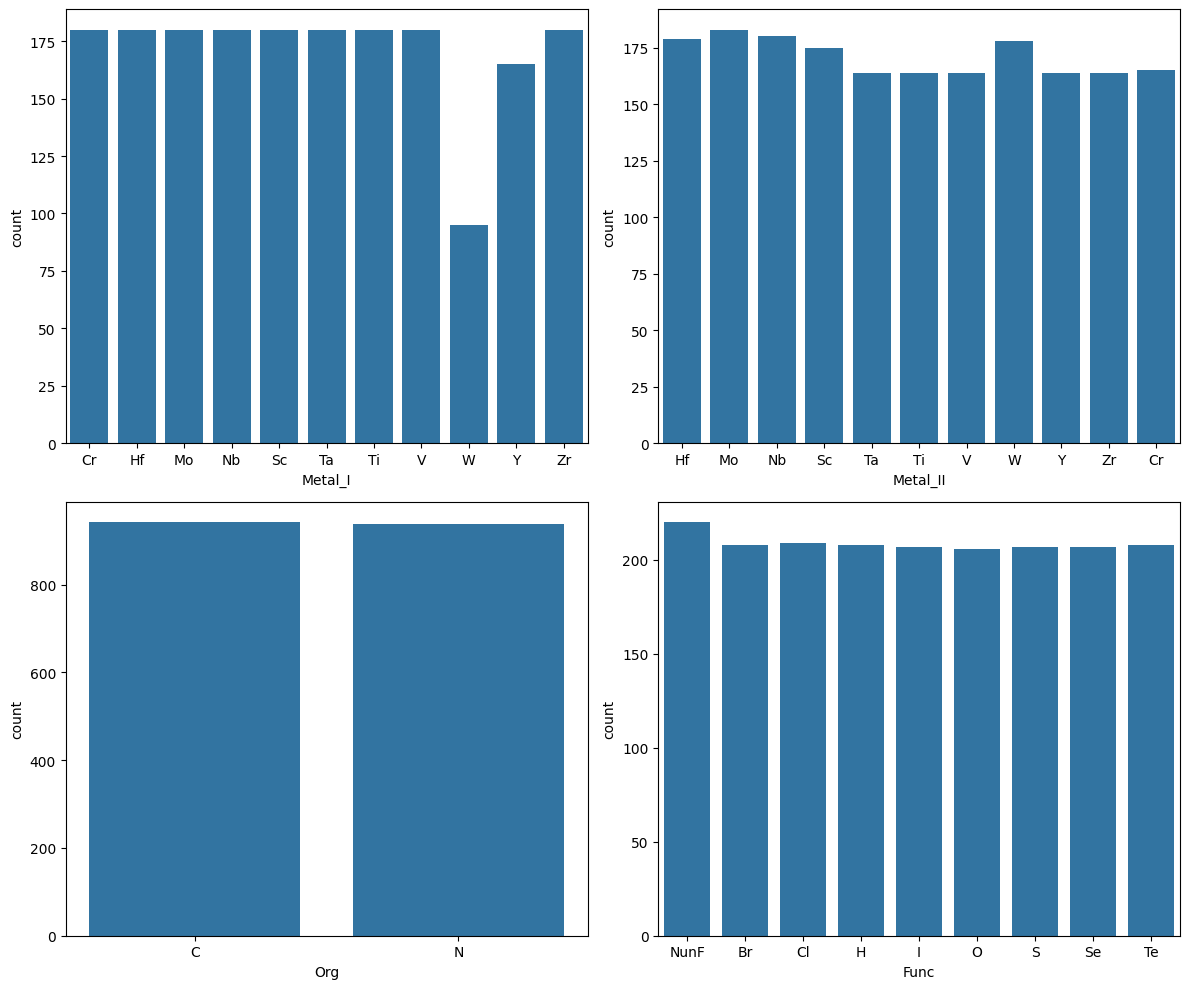

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, column in enumerate(df.columns[:-1]):
    sns.countplot(x=column, data=df, ax=axes[i // 2, i % 2])

# Visualize the target variable
sns.histplot(x='0.1Bar', data=df, ax=axes[1, 0])

plt.tight_layout()
plt.show()

## Encoding

In [ ]:
df_encoded = pd.get_dummies(df, columns = ['Metal_I', 'Metal_II', 'Org', 'Func'])


In [ ]:
X = df_encoded.drop('0.1Bar', axis=1)
y = df_encoded['0.1Bar']

In [ ]:
X

,Metal_I_Cr,Metal_I_Hf,Metal_I_Mo,Metal_I_Nb,Metal_I_Sc,Metal_I_Ta,Metal_I_Ti,Metal_I_V,Metal_I_W,Metal_I_Y,...,Org_N,Func_Br,Func_Cl,Func_H,Func_I,Func_NunF,Func_O,Func_S,Func_Se,Func_Te
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1876,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1877,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1878,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
y

0       0.000875
1       0.000535
2       0.000820
3       0.001186
4       0.000283
          ...   
1875    0.000015
1876    0.000892
1877    0.000346
1878    0.000119
1879    0.000015
Name: 0.1Bar, Length: 1880, dtype: float64


## Correlation *Matrix*

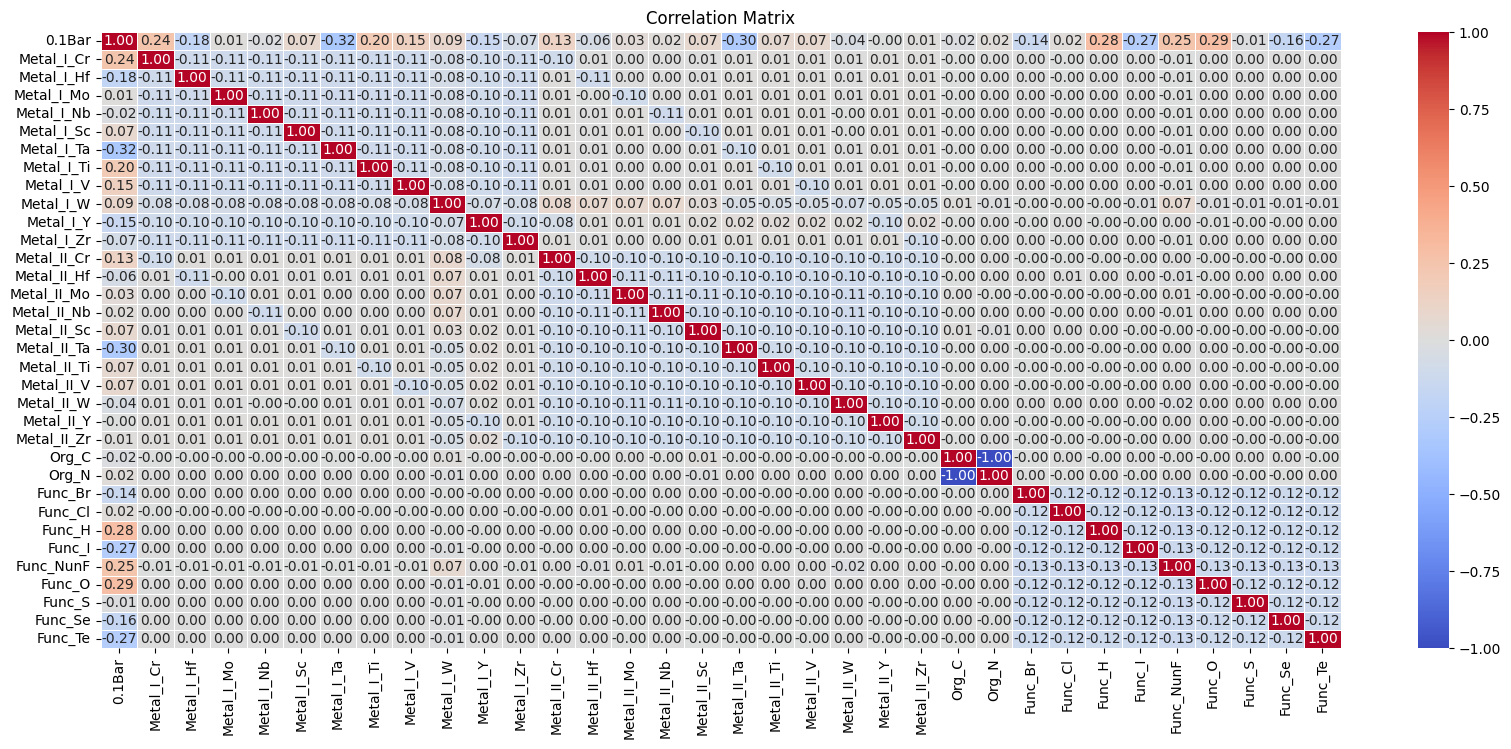

In [ ]:
# Compute correlation matrix
correlation_matrix = df_encoded.corr()

# Plotting the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## PCA

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
n_components = 20

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [ ]:
model_pca = XGBRegressor()
model_pca.fit(X_train_pca, y_train_pca)

predictions_pca = model_pca.predict(X_test_pca)

mse_pca = mean_squared_error(y_test_pca, predictions_pca)
print(f'Mean Squared Error with PCA: {mse_pca}')

Mean Squared Error with PCA: 2.9518560202971865e-08


# Predict with Hand

In [ ]:
test_data = pd.DataFrame({'Metal_I': ['Cr'],
                          'Metal_II': ['V'],
                          'Org': ['C'],
                          'Func': ['NunF']})


In [ ]:
training_columns = X.columns.tolist()
test_data_encoded = pd.get_dummies(test_data)
test_data_encoded = test_data_encoded.reindex(columns=training_columns, fill_value=0)
test_data_scaled = scaler.transform(test_data_encoded)
test_data_pca = pca.transform(test_data_scaled)
prediction = model_pca.predict(test_data_pca)

In [ ]:
print("Predicted value:", prediction)


Predicted value: [0.00154225]


## Multi Model Comparisons

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
predictions_models = {}

r2_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    start_time = time.time()
    predictions_models[name] = model.predict(X_test)
    end_time = time.time()


    mse = mean_squared_error(y_test, predictions_models[name])

    r2 = r2_score(y_test, predictions_models[name])
    r2_scores[name] = r2
    print(f'{name} - Mean Squared Error: {mse}, R2 Score: {r2}')

    # prediction time
    prediction_time_ms = (end_time - start_time) * 1000
    print(f"Prediction Time: {prediction_time_ms:.2f} milliseconds")

Linear Regression - Mean Squared Error: 5.882214045354083e-08, R2 Score: 0.782199474341499
Prediction Time: 6.27 milliseconds
Ridge Regression - Mean Squared Error: 5.8958444204222086e-08, R2 Score: 0.78169478293927
Prediction Time: 4.71 milliseconds
Lasso Regression - Mean Squared Error: 2.7043203650706007e-07, R2 Score: -0.001327718644606124
Prediction Time: 9.40 milliseconds
Decision Tree Regressor - Mean Squared Error: 1.6989539271131776e-08, R2 Score: 0.9370928946920785
Prediction Time: 2.62 milliseconds
Random Forest Regressor - Mean Squared Error: 1.1624810654356052e-08, R2 Score: 0.9569568558424181
Prediction Time: 12.34 milliseconds
XGBoost Regression - Mean Squared Error: 2.7483890273114644e-08, R2 Score: 0.8982354993804955
Prediction Time: 6.82 milliseconds


##Multi Model Prediction Plot

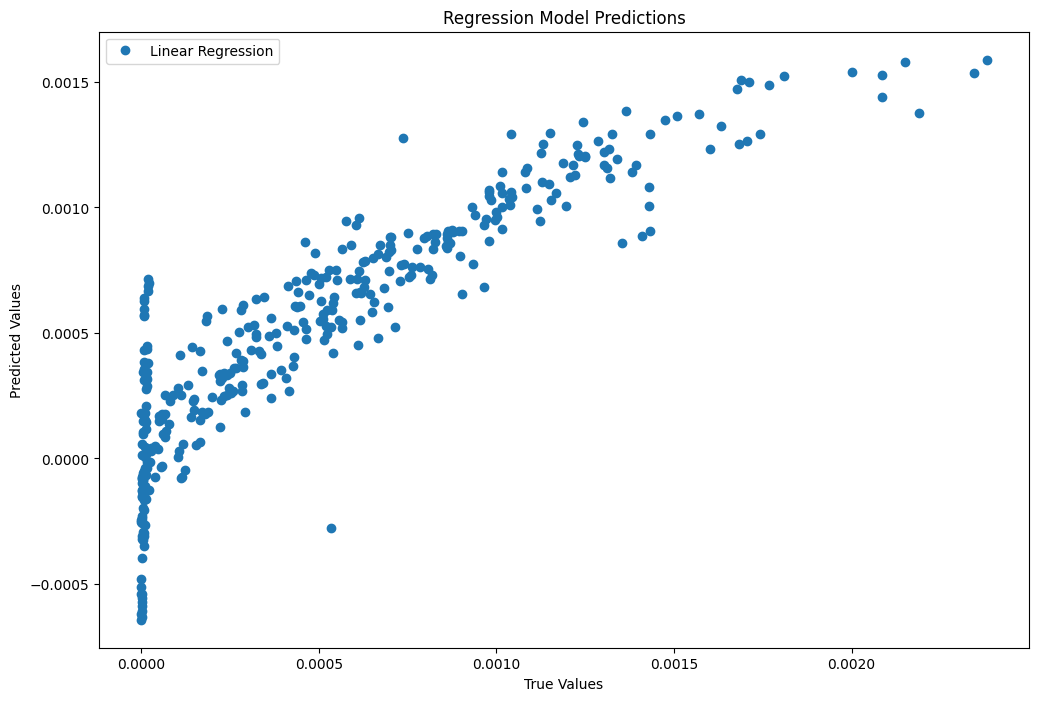

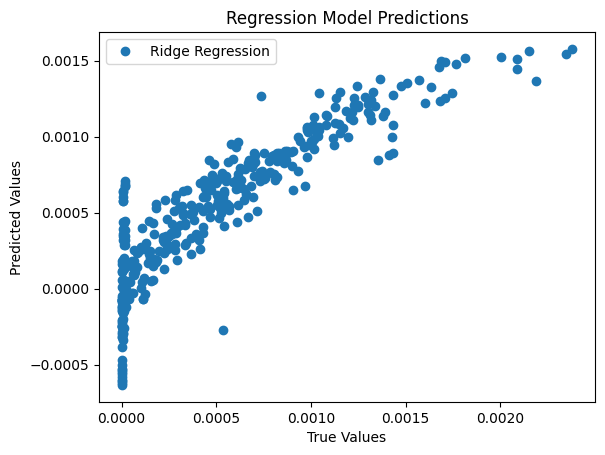

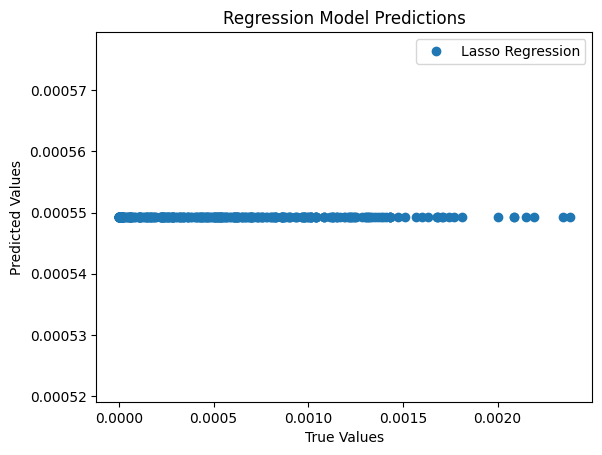

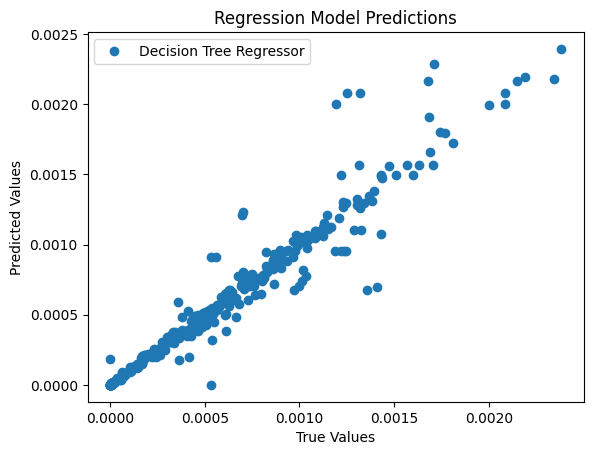

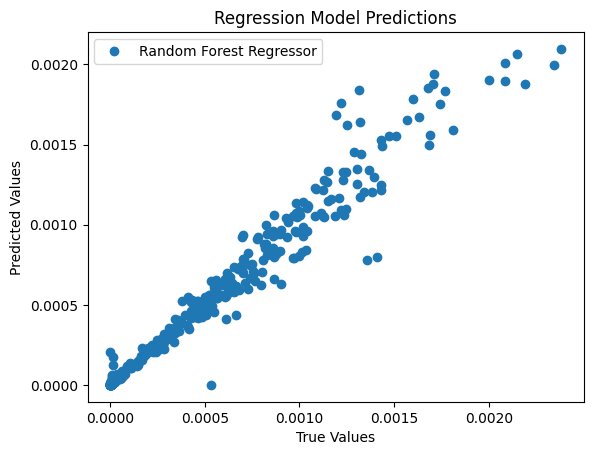

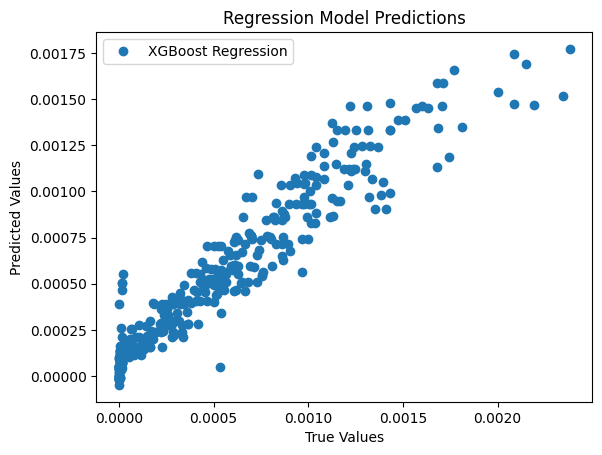

In [ ]:
# Plot the predictions
plt.figure(figsize=(12, 8))
for name, prediction in predictions_models.items():
  plt.plot(y_test, prediction, marker='o', linestyle='', label=name)
  plt.title('Regression Model Predictions')
  plt.xlabel('True Values')
  plt.ylabel('Predicted Values')
  plt.legend()
  plt.show()

In [ ]:
zy = y

In [ ]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
start_time = time.time()
predictions = model.predict(X_test)
end_time = time.time()


import sys

number_of_prediction = sys.getsizeof(predictions)

# prediction time
prediction_time_ms = (end_time - start_time) * 1000
print(f"Total Prediction Time: {prediction_time_ms:.2f} milliseconds")
print(f"Prediction Time: {prediction_time_ms/number_of_prediction:.2f} milliseconds")


Total Prediction Time: 14.72 milliseconds
Prediction Time: 0.13 milliseconds


In [ ]:
predictions

array([ 1.26930675e-03,  1.61536518e-04,  2.92549172e-04,  9.86803789e-05,
        7.38783099e-04,  3.43372492e-04,  5.72004763e-04,  9.31911753e-04,
        5.00129128e-04,  1.38821884e-03,  5.08171215e-04,  3.29841801e-04,
        1.11972960e-03,  3.64435313e-04,  9.69936664e-05,  1.03571037e-04,
        5.59687673e-04,  5.53382037e-04,  4.64042241e-05,  1.03982027e-04,
        4.67192498e-04,  9.25335771e-05,  5.72004763e-04,  4.41038050e-04,
        1.38821884e-03,  3.64435313e-04,  3.46037385e-04,  4.67192498e-04,
        3.05586844e-04,  2.98795523e-04,  8.77151615e-04,  1.77123491e-03,
        4.93314641e-04,  7.58928072e-05,  8.13961037e-07,  9.69936664e-05,
        3.92942311e-04, -1.41344435e-05,  5.93745906e-04,  1.03571037e-04,
        3.77555189e-05,  8.73903991e-05,  7.56962399e-04,  5.78281004e-04,
        1.88021404e-05,  6.58194185e-04,  2.13073305e-04,  5.53382037e-04,
        2.79833941e-04,  1.56082780e-04,  1.40895194e-04,  3.92377289e-04,
        1.03571037e-04,  

In [ ]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.7483890273114644e-08


In [ ]:
X_test.to_excel(excel_writer = "X_test.xlsx")

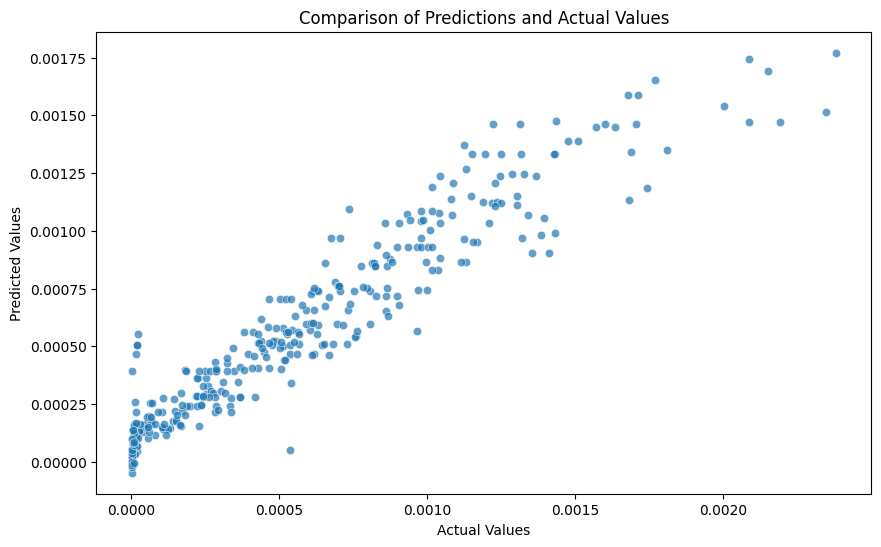

In [ ]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})


# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df, alpha=0.7)
plt.title('Comparison of Predictions and Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("RMSE: %f" % (rmse))

RMSE: 0.000166


In [ ]:
r2 = 1 - (rmse**2)
print(f"R^2 Score: {r2}")

R^2 Score: 0.9999999725161097
